# DeepQ Stock Trading Agent Training

In [1]:
%cd ../../

In [2]:
from traders.deep_q.agent import DeepQAgent
from traders.deep_q.state import State
from traders.deep_q.helpers import *

import numpy as np 
import pandas as pd
import math
import random
import sys
from datetime import datetime, timedelta

In [3]:
# Setup parameters
stock_name1 = 'AAPL'
stock_name2 = 'TSLA'
episode_count = 51
start_balance = 10000
training = 1500
test = 500

In [4]:
# Load data
from utils.data.stock_price_data import *

stock_one_data = get_stock_data(stock_name1)
stock_two_data = get_stock_data(stock_name2)

/Users/mitsunari/Documents/Quantative-Trading-Strategy-Platform/venv/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Data Pre-processing
In this section:

- Look at the data and checking for anamolies (missing data etc.).
- Convert date into right format. 
- Make sure that both the stock data is for the same time period and same days in this time period. Remove data if necessary.   
- Look at descriptive statistics of data- mean, median, number of records.
- Visualize the data to see how stock price changes with time

### Checking data format

In [5]:
stock_one_data.reset_index(level=0, inplace=True)
stock_one_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-09-08,28.139999,27.580000,27.937500,28.077499,219374400.0,25.946814
1,2015-09-09,28.504999,27.442499,28.440001,27.537500,340043200.0,25.447792
2,2015-09-10,28.320000,27.475000,27.567499,28.142500,251571200.0,26.006878
3,2015-09-11,28.552500,27.940001,27.947500,28.552500,199662000.0,26.385771
4,2015-09-14,29.222500,28.715000,29.145000,28.827499,233453600.0,26.639898


In [6]:
stock_two_data.reset_index(level=0, inplace=True)
stock_two_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-09-08,49.832001,48.810001,49.009998,49.633999,15691000.0,49.633999
1,2015-09-09,50.849998,49.660000,50.410000,49.782001,16954000.0,49.782001
2,2015-09-10,50.144001,49.066002,49.445999,49.695999,13545000.0,49.695999
3,2015-09-11,50.048000,48.945999,49.528000,50.048000,11754000.0,50.048000
4,2015-09-14,50.849998,49.933998,50.220001,50.638000,14454500.0,50.638000


### Data descriptions

In [7]:
stock_one_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,46.375645,45.451501,45.895473,45.945999,1.367339e+08,44.741487
std,19.932868,19.303272,19.624119,19.658004,6.263313e+07,20.126807
min,22.917500,22.367500,22.500000,22.584999,4.544800e+07,21.202499
25%,29.596251,29.195000,29.395000,29.425000,9.436500e+07,27.647054
50%,43.035000,42.372501,42.650002,42.722500,1.195616e+08,41.378620
75%,53.375000,52.208750,52.687500,52.588751,1.624404e+08,51.761433
max,137.979996,130.529999,137.589996,134.179993,5.334788e+08,134.179993


In [8]:
stock_two_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,75.824801,72.464618,74.169341,74.245438,4.148259e+07,74.245438
std,63.007735,58.366736,60.759077,60.981524,3.030278e+07,60.981524
min,30.993999,28.209999,28.464001,28.733999,3.540000e+06,28.733999
25%,46.482000,45.109001,45.868000,45.923000,2.209425e+07,45.923000
50%,60.202000,57.910000,59.348000,59.077999,3.186850e+07,59.077999
75%,69.999001,67.846001,69.033001,69.018997,4.971175e+07,69.018997
max,502.489990,470.510010,502.140015,498.320007,3.046940e+08,498.320007


In [9]:
from utils.data.preprocessing import *

In [10]:
if stock_one_data.shape != stock_two_data.shape:
    print('Data not clean, needs some cleansing')
    stock_one_data, stock_two_data = make_data_match(stock_one_data, stock_two_data)
else:
    print("data is matching!")

data is matching!


In [11]:
assert stock_one_data.shape == stock_two_data.shape

### Data Visualisation

In [12]:
from utils.data.visualisation import StockVisualiser

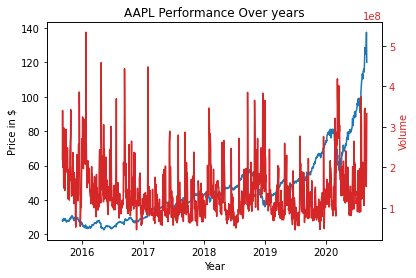

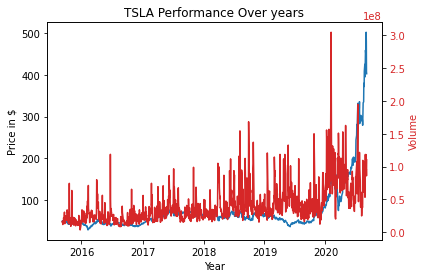

In [13]:
stock_1_visualiser = StockVisualiser(stock_name1, stock_one_data)
stock_2_visualiser = StockVisualiser(stock_name2, stock_two_data)

stock_1_visualiser.plot()
stock_2_visualiser.plot()

### Dividing training and test datasets

Due to correlation of stock prices between each days, this has to be in chronological order.

In [14]:
#Training and Testing Data
stock_one_data_train, stock_one_data_test = get_train_test_split(stock_one_data, training, test)
stock_two_data_train, stock_two_data_test = get_train_test_split(stock_two_data, training, test)

### Benchmark model

In [19]:
# Initialize state
total_profit=[]
done=False
batch_size = 64
act_datasize = len(stock_one_data_train)
batch_size = 64

# Benchmark Model
train_one_open = stock_one_data_train['Open']
train_two_open = stock_two_data_train['Open']

train_one_date = stock_one_data_train['Date']

act_bench_stock1_bal = int(np.floor((start_balance/4) / train_one_open[0]))
act_bench_stock2_bal = int(np.floor((start_balance/4) / train_two_open[0]))
act_benchmark_open_cash = start_balance/2

# Program to calculate benchmark profit
# sell 10% of stock in 10 intervals

interval = int(act_datasize/10)
total_stock1_amount= 0
total_stock2_amount= 0
stocks_one_value = 0
stocks_two_value = 0

act_stocks_one = np.floor(act_bench_stock1_bal / 10)
act_stocks_two = np.floor(act_bench_stock2_bal / 10)

remaining_stock1 = act_bench_stock1_bal
remaining_stock2 = act_bench_stock2_bal

benchmark_portfolio_value = []

for j in range(interval, act_datasize+1, interval):
    print("closing prices : {}".format(train_one_open[j-1]))
    stock_one_price_closing = train_one_open[j-1]
    stock_two_price_closing = train_two_open[j-1]
        
    stock_one_date = train_one_date[j-1].strftime('%Y-%m-%d')
                
    stocks_one_value = act_stocks_one * stock_one_price_closing
    stocks_two_value = act_stocks_two * stock_two_price_closing
    remaining_stock1 = remaining_stock1 - act_stocks_one
    remaining_stock2 = remaining_stock2 - act_stocks_two
        
    stock1_portfolio_value = remaining_stock1 * stock_one_price_closing
    stock2_portfolio_value = remaining_stock2 * stock_two_price_closing
    act_benchmark_open_cash = act_benchmark_open_cash + stocks_one_value + stocks_two_value #Adding 10% sold value into open cash
        
    total_portfolio_value = act_benchmark_open_cash + stock1_portfolio_value + stock2_portfolio_value
    benchmark_portfolio_value.append([stock_one_date, total_portfolio_value])
        
training_benchmark_portfolio_value = total_portfolio_value

print('Benchmark profit is: {} with {} remaining {} stocks and {} remaining {} stocks'.format(
    training_benchmark_portfolio_value, stock_name1, remaining_stock1, stock_name2, remaining_stock2))


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

closing prices : 25.137500762939453
closing prices : 23.540000915527344
closing prices : 28.587499618530273
closing prices : 30.232500076293945
closing prices : 38.474998474121094
closing prices : 39.01499938964844
closing prices : 42.4474983215332
closing prices : 46.529998779296875
closing prices : 53.974998474121094
closing prices : 43.467498779296875
Benchmark profit is: 11252.545475006104 with AAPL remaining 9.0 stocks and TSLA remaining 1.0 stocks
